**Importing Libraries**

In [184]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import Normalizer # For Normalization
from sklearn.preprocessing import StandardScaler # For Standardization
from sklearn.decomposition import PCA

**Loading Data Set CIFAR 10 & Splitting it in train-test set**

Επειδή το cifar10 dataset είναι αρκερά μεγάλο επιλέγω να πάρω μόνο 10000 εικόνες τυχαία ως main dataset το οποίο θα το χωρίσω σε train-validation-test.

In [185]:
# loading cifar10 dataset
cifar10 = tf.keras.datasets.cifar10
(X, y), (X_test, y_test) = cifar10.load_data() # load cifar10

# combine train and test dataset
X_full = np.concatenate((X, X_test), axis=0)
y_full = np.concatenate((y, y_test), axis=0)

# select a random subset
subset_size = 10000
indices = np.random.choice(len(X_full), size=subset_size, replace=False)
X_full = X_full[indices]
y_full = y_full[indices]

# Split data into train-validation-test sets (60%-30%-10%)
X_train, X_test, y_train, y_test = train_test_split(X_full, y_full, test_size=0.4,
                                                    random_state=0)

X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5,
                                                random_state=0)

**Visualizing dataset samples**

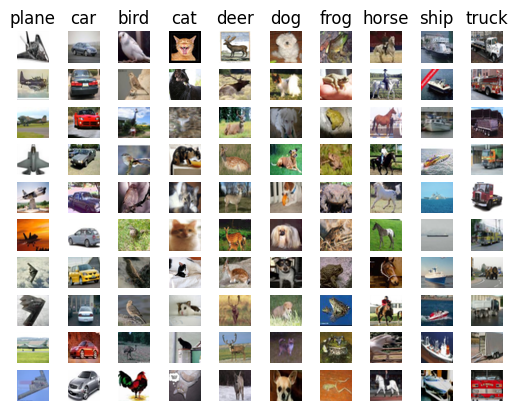

In [186]:
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 10
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

**Data Preprocessing**

Στάδιο προεπεξεργασίας των δεδομένων. Μετατρέπω τις εικόνες σε μονοδιάστατα διανύσματα και ελέγχω εαν η μετατροπή έγινε σωστά εμφανίζοντας το shape των δεδομένων.

In [187]:
# Reshaping Data into vectors
X_train = X_train.reshape(X_train.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)
X_val = X_val.reshape(X_val.shape[0], -1)

print("X_train.shape: {}\ny_train.shape: {}\nX_test.shape: {}\ny_test.shape: {}\nX_val.shape: {}\ny_val.shape: {}".format(X_train.shape, y_train.shape,
                                                                                                                          X_test.shape, y_test.shape,
                                                                                                                          X_val.shape, y_val.shape))

X_train.shape: (6000, 3072)
y_train.shape: (6000, 1)
X_test.shape: (2000, 3072)
y_test.shape: (2000, 1)
X_val.shape: (2000, 3072)
y_val.shape: (2000, 1)


Δοκιμάζω δύο διαφορετικές κανονικοποιήσεις των δεδομένων (Standardization & Normalization).

Επιλέγω να κάνω τα Normalization/Standardization πριν την εφαρμογή του pca, ώστε όταν θα κάνω το pca όλα τα χαρακτηριστικά να συμβάλλουν ισότιμα στην δημιουργία του υπερεπιπέδου.

Standardization: Μετατρέπει τα δεδομένα σε κανονική κατανομή με μέση τιμή ίση με 0 και η τυπική απόκλιση ίση με 1 (mean=0 & std=1).

Normalization: Σε αυτή την περίπτωση τα δεδομένα απεικονίζονται σε ένα συγκριμένο έυρος 0 έως 1 και όλα τα χαρακτηριστικά έχουν την ίδια συνεισφορά.

In [188]:
# Check the data range before normalization/standardization process
np.min(X_train), np.max(X_train)

(0, 255)

In [189]:
# Standardization of data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

np.min(X_train), np.max(X_train)

(-2.2116631198895558, 2.6823288204438045)

In [190]:
# pca for dimensionality reduction
pca_cifar = PCA(n_components=50)
X_train = pca_cifar.fit_transform(X_train)
X_val = pca_cifar.transform(X_val)
X_test = pca_cifar.transform(X_test)

print("X_train.shape: {}\ny_train.shape: {}\nX_test.shape: {}\ny_test.shape: {}\nX_val.shape: {}\ny_val.shape: {}".format(X_train.shape, y_train.shape,
                                                                                                                          X_test.shape, y_test.shape,
                                                                                                                          X_val.shape, y_val.shape))

X_train.shape: (6000, 50)
y_train.shape: (6000, 1)
X_test.shape: (2000, 50)
y_test.shape: (2000, 1)
X_val.shape: (2000, 50)
y_val.shape: (2000, 1)


Με μία forloop() δοκιμάζω για ένα εύρος γειτόνων από 1 έως 100 (k = {1, 100}) χωρίς να πειράξω τις υπόλοιπες παραμέτρους και εμφανίζω το k που δίνει την καλύτερη ακρίβεια.
Σε αυτή τη περίπτωση το καλύερο k=26 και δίνει ακρίβεια acc= 0.331.

Performing K-Nearest Neighbors (K-NN)

In [191]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
accuracies = []
best_accuracy = 0
best_k = 0
yi = []

for i in range (1, 100):

  knn_model = KNeighborsClassifier(n_neighbors=i)
  knn_model.fit(X_train, y_train)
  knn_pred = knn_model.predict(X_test)
  acc = metrics.accuracy_score(y_test, knn_pred)
  accuracies.append(acc)
  yi.append(i)

  if acc > best_accuracy:
    best_accuracy = acc
    best_k = i

print(f"Best accuracy: {best_accuracy} with n_neighbors = {best_k}")



/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for 

Best accuracy: 0.3455 with n_neighbors = 21


Κάνω plot για να δω την διακύμανση της ακρίβειας σε συνάρτηση με τον αριθμό των γειτόνων και παρατηρώ ότι καθώς αυξάνεται ο αριθμός των γειτόνων τόσο κατρακυλάει η ακρίβεια.

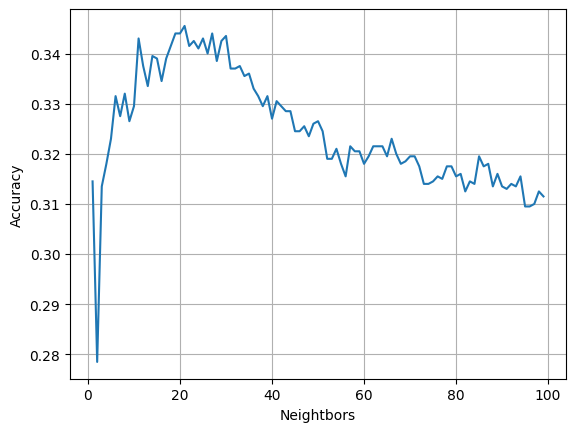

In [194]:
plt.plot( yi, accuracies)
plt.ylabel('Accuracy')
plt.xlabel('Neightbors')
plt.grid(True)
plt.show()

**Cross Validation** & **Prediction with the Best Model**

Κάνω 5-fold & 10-fold Cross Validation στον k-NN δοκιμάζοντας διαφορετικές παραμέτρους. Όσο αφορά στους γείτονες συμπεριλαμβάνω τον αριθμό των γειτόνων με την καλύερη ακρίβεια και 6 ακομα τιμές γύρω από την "καλύτερη" τιμή που βρήκαμε (k=26).


In [193]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

knn_model1 = KNeighborsClassifier()
param_grid1 = {
    'n_neighbors': [7, 9, 11, 13, 17, 26, 33],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

grid_search1 = GridSearchCV(knn_model1, param_grid1, cv=5, n_jobs=-1)

grid_search1.fit(X_train, y_train.ravel())

best_knn_model1 = grid_search1.best_estimator_
print("Best Hyperparameters:", best_knn_model1)

Best Hyperparameters: KNeighborsClassifier(metric='euclidean', n_neighbors=13, weights='distance')


In [195]:
# Train set Accuracy
y_train_pred = best_knn_model1.predict(X_train)
train_accuracy = accuracy_score(y_train.ravel(), y_train_pred)
print("Train Set Accuracy:", train_accuracy)

# Validation set Accuracy
y_val_pred = best_knn_model1.predict(X_val)
val_accuracy = accuracy_score(y_val.ravel(), y_val_pred)
print("Validation Set Accuracy:", val_accuracy)

# Test set Accuracy
y_test_pred = best_knn_model1.predict(X_test)
test_accuracy = accuracy_score(y_test.ravel(), y_test_pred)
print("Test Set Accuracy:", test_accuracy)

Train Set Accuracy: 1.0
Validation Set Accuracy: 0.332
Test Set Accuracy: 0.3465


In [196]:
knn_model2 = KNeighborsClassifier()
param_grid2 = {
    'n_neighbors': [7, 9, 11, 13, 17, 26, 33],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

grid_search2 = GridSearchCV(knn_model2, param_grid2, cv=10, n_jobs=-1)

grid_search2.fit(X_train, y_train.ravel())

best_knn_model2 = grid_search2.best_estimator_
print("Best Hyperparameters:", best_knn_model2)

Best Hyperparameters: KNeighborsClassifier(metric='euclidean', n_neighbors=13, weights='distance')


In [87]:
# Train set Accuracy
y_train_pred = best_knn_model2.predict(X_train)
train_accuracy = accuracy_score(y_train.ravel(), y_train_pred)
print("Train Set Accuracy:", train_accuracy)

# Validation set Accuracy
y_val_pred = best_knn_model2.predict(X_val)
val_accuracy = accuracy_score(y_val.ravel(), y_val_pred)
print("Validation Set Accuracy:", val_accuracy)

# Test set Accuracy
y_test_pred = best_knn_model2.predict(X_test)
test_accuracy = accuracy_score(y_test.ravel(), y_test_pred)
print("Test Set Accuracy:", test_accuracy)

Train Set Accuracy: 1.0
Validation Set Accuracy: 0.321
Test Set Accuracy: 0.3365


Παρατηρώ ότι για cv=5 ο καλύτερος αριθμός γειτόνων είναι k = 11 ενώ για cv=10 είναι k = 7. Οι άλλες δύο παράμετροι είναι ακριβώς οι ίδιες (metric='euclidean' και weights='distance'). Η ακρίβεια στα validation set και test set έχει μια πάρα πολύ μικρή διαφορά που θα μπορούσαμε να τη θεωρήσουμε και αμελητέα. Επίσης παρατηρώ έντονα το φαινόμενο του overfitting καθώς βλέπουμε acc=1 στο train set ενώ στα validation-test 0.33, άρα το μοντέλο δεν μπορεί να κάνει καλή γενίκευση σε άγνωστα δεδομένα.



Plot correct & incorrect prediction

In [197]:
import pandas as pd

knn_pred = best_knn_model1.predict(X_test)
knn_results = knn_pred[:20].ravel()
yTest_results = y_test[:20].ravel()

# DataFrame with predicted and actual values
results_df = pd.DataFrame({
    'Prediction': knn_results,
    'Actual Value': yTest_results
})

# print the dataframe
print(results_df)

    Prediction  Actual Value
0            2             9
1            0             2
2            0             9
3            2             0
4            6             0
5            8             8
6            6             6
7            2             2
8            7             7
9            7             7
10           4             6
11           4             3
12           2             0
13           7             7
14           6             6
15           6             4
16           0             5
17           2             5
18           6             3
19           4             4


In [198]:
# Create lists for correct and incorrect predictions
correct_predictions = []
incorrect_predictions = []

for i in range(len(knn_results)):
    if knn_results[i] == yTest_results[i]:
        correct_predictions.append(i)
    else:
        incorrect_predictions.append(i)

print("Correct Predictions:", correct_predictions)
print("Incorrect Predictions:", incorrect_predictions)

Correct Predictions: [5, 6, 7, 8, 9, 13, 14, 19]
Incorrect Predictions: [0, 1, 2, 3, 4, 10, 11, 12, 15, 16, 17, 18]


In [202]:
# Data reconstruction
X_test_reconstructed = pca_cifar.inverse_transform(X_test)

X_test_reconstructed = np.clip(X_test_reconstructed, 0, 1)
X_test_reconstructed = X_test_reconstructed.astype(np.float32)

In [203]:
import numpy as np
import matplotlib.pyplot as plt

# Class names
classesName = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Image preparation
def plt_img(x):
    nrow = 32
    ncol = 32
    ncolors = 3
    xsq = x.reshape((nrow, ncol, ncolors))
    plt.imshow(xsq)

# Number of images to plot (2 correct & 2 incorrect)
nplt = 2

# Plot correct predictions
plt.figure(figsize=(12, 6))

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<ipython-input-204-a46b37dfaec6>:8: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  true_label = classesName[int(y_test[ind])]  # actual label


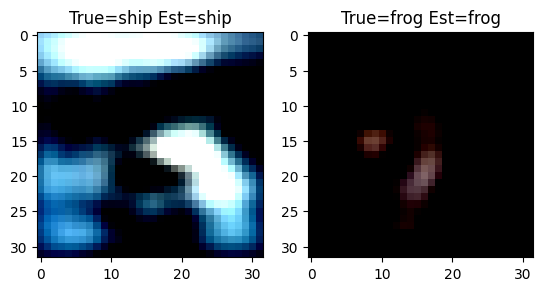

In [204]:
# Plot correct predictions
for i in range(nplt):
   plt.subplot(1, nplt, i + 1)
   ind = correct_predictions[i]  # select the correct sample
   plt_img(X_test_reconstructed[ind, :])  # use of reconstructed data for plotting

   # Actual and Predicted label
   true_label = classesName[int(y_test[ind])]  # actual label
   est_label = classesName[int(knn_pred[ind])]  # predicted label

   # Τίτλος εικόνας
   plt.title(f'True={true_label} Est={est_label}')

<ipython-input-205-17b124db65b1>:8: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  true_label = classesName[int(y_test[ind])]  # actual label


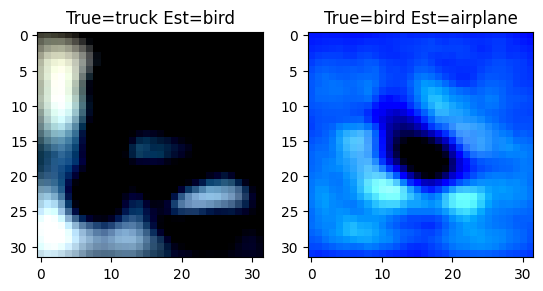

In [205]:
# Plot incorrect predictions
for i in range(nplt):
    plt.subplot(1, nplt, i + 1)
    ind = incorrect_predictions[i] # select the incorrect sample
    plt_img(X_test_reconstructed[ind, :]) # use of reconstructed data for plotting

    # Actual and Predicted label
    true_label = classesName[int(y_test[ind])]  # actual label
    est_label = classesName[int(knn_pred[ind])]  # predicted label

    # Τίτλος εικόνας
    plt.title(f'True={true_label} Est={est_label}')